## 1 SGD

In [1]:
from torch.nn.parameter import Parameter
from torch.optim.lr_scheduler import ExponentialLR
import torch
from sklearn.datasets import make_regression
from torch.utils.data import TensorDataset, DataLoader, Dataset
import copy

# 定义数据
X,Y = make_regression(n_samples=10, n_features=1,n_targets=1,noise=1.5,random_state=1)
dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(Y).float())
dataloader = DataLoader(dataset, shuffle=False, drop_last=True, batch_size=1)

# 定义参数
model = torch.nn.Linear(1,1)
def optim(model, optim_fn, lr, weight_decay=0):   
  model_ = copy.deepcopy(model)
  # 提取第一个参数
  w0 = [list(model_.weight)[0].data.numpy()[0]]
  optimizer = optim_fn(model_.parameters(), lr=lr, weight_decay=weight_decay)
  # scheduler = ExponentialLR(optimizer, gamma=0.9)
  loss_fn = torch.nn.MSELoss()

  for epoch in range(10):
    for input, target in dataloader:
      optimizer.zero_grad()
      output = model_(input)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      w0.append(list(model_.weight)[0].data.numpy()[0])
    # scheduler.step()
  return w0

In [2]:
import matplotlib.pyplot as plt

def plot(w_list, titles):
  plt.figure(figsize=(len(titles)*6,5))
  for i, w in enumerate(w_list):
    plt.subplot(1,len(titles),i+1)
    plt.plot(range(len(w)), w)
    plt.title(titles[i])
    plt.grid()
    plt.yticks(range(0,5))
    plt.xlabel('epochs*10')
    plt.ylabel('weight')
  plt.show()

In [3]:
import warnings
import functools
from collections import defaultdict

class CustomOptimizer:

  def __init__(self,params,defaults):

    self.defaults = defaults

    """
    defaultdict的作用在于当字典里的key被查找但不存在时，
        返回的不是keyError而是一个默认值，
        此处defaultdict(dict)返回的默认值会是个空字典。
    """    
    self.state = defaultdict(dict)

    self.param_groups=[]
    param_groups = list(params)

    if len(param_groups)==0:
      raise ValueError('optimizer got an empty parameter list')

    if not isinstance(param_groups[0], dict):
      param_groups = [{'params':param_groups}]

    for param_group in param_groups:
      self.add_param_group(param_group)

  def add_param_group(self, param_group):
    """
    作用是将param_group放进self.param_groups中
    param_group是字典，Key是params，Value是param_groups=list(params)
    """

    assert isinstance(param_group, dict), "param group must be a dict"

    params = param_group['params']

    if isinstance(params, torch.Tensor):
      param_group['params'] = [params]
    else:
      param_group['params'] = list(params)
    
    """将self.defaults中的键值对遍历放到字典param_group中"""
    for name, default in self.defaults.items():
      param_group.setdefault(name, default)
    
    params = param_group['params']

    if len(params) != len(set(params)):
      warnings.warn("optimizer contains a parameter group with duplicate parameters; "
                    "in future, this will cause an error; ",stacklevel=3)

    """对self.param_groups和param_group中的元素进行判断，确保没有重复的参数"""
    param_set = set()
    for group in self.param_groups:
        param_set.update(set(group['params']))

    if not param_set.isdisjoint(set(param_group['params'])):
        raise ValueError("some parameters appear in more than one parameter group")

    """将字典param_group放进列表self.param_groups"""
    self.param_groups.append(param_group)
  
  def __setstate__(self, state):
    self.__dict__.update(state)

  def __getstate__(self):
    return {
        'defaults': self.defaults,
        'state': self.state,
        'param_groups': self.param_groups,
    }

  def step(self, closure):
    raise NotImplementedError

  def zero_grad(self):
    r"""将梯度置为零"""
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is not None:
          p.grad.detach_()
          p.grad.zero_()

  def __repr__(self):
    format_string = self.__class__.__name__ + ' ('
    for i, group in enumerate(self.param_groups):
      format_string += '\n'
      format_string += 'Parameter Group {0}\n'.format(i)
      for key in sorted(group.keys()):
        if key != 'params':
          format_string += '    {0}: {1}\n'.format(key, group[key])
    format_string += ')'
    return format_string

In [4]:
class CustomSGD(CustomOptimizer):
  def __init__(self,params,lr,momentum=0,dampening=0,weight_decay=0,nesterov=False,maximize=False):
    
    """参数被打包进字典中命名为defaults"""
    defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
            weight_decay=weight_decay, nesterov=nesterov, maximize=maximize)
    super(CustomSGD, self).__init__(params, defaults)
  
  def __setstate__(self, state):
    super(CustomSGD, self).__setstate__(state)
    for group in self.param_groups:
      group.setdefault('nesterov', False)
      group.setdefault('maximize', False)
  
  @torch.no_grad()
  def step(self, closure=None):
    """更新参数
    Arguments:
      closure (callable, optional): A closure that reevaluates the model
          and returns the loss.
    """
    loss = None
    if closure is not None:
        loss = closure()

    """self.param_groups 是在父类的__init__函数中创建的"""
    for group in self.param_groups:
      weight_decay = group['weight_decay']
      momentum = group['momentum']
      dampening = group['dampening']
      nesterov = group['nesterov']
      maximize = group['maximize']

      for p in group['params']:
        if p.grad is None: continue
        d_p = p.grad.data
        if weight_decay != 0:
          d_p.add_(weight_decay, p.data)
        if momentum != 0:
          param_state = self.state[p]
          if 'momentum_buffer' not in param_state:
            buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
          else:
            buf = param_state['momentum_buffer']
            buf.mul_(momentum).add_(1 - dampening, d_p)
          if nesterov:
            d_p = d_p.add(momentum, buf)
          else:
            d_p = buf
        
        # 对参数进行更新
        if maximize:
          p.data.add_(group['lr'], d_p)
        else:
          p.data.add_(-group['lr'], d_p)
    return loss


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)


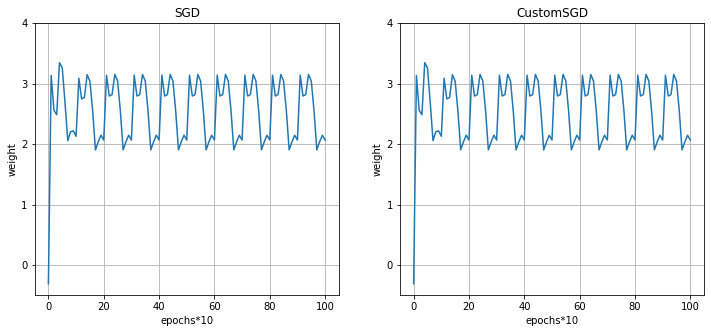

In [5]:
from torch.optim import SGD
w0=optim(model, optim_fn=SGD, lr=0.1,weight_decay=0.5)
w0_custom = optim(model, optim_fn=CustomSGD, lr=0.1,weight_decay=0.5)
plot([w0,w0_custom], titles=['SGD','CustomSGD'])

## 2 Adam

In [6]:
import math

class CustomAdam(CustomOptimizer):
  def __init__(self, params,lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False,maximize=False):
    defaults = dict(lr=lr, betas=betas, eps=eps,
            weight_decay=weight_decay, amsgrad=amsgrad, maximize=maximize)
    super(CustomAdam, self).__init__(params, defaults)
  
  def __setstate__(self, state):
    super(CustomAdam, self).__setstate__(state)
    for group in self.param_groups:
      group.setdefault('amsgrad', False)
      group.setdefault('maximize', False)
  
  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
        loss = closure()

    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None: continue
        
        if group['maximize']:
          grad = -p.grad.data
        else:
          grad = p.grad.data

        if group['weight_decay'] != 0:
          grad.add_(group['weight_decay'], p.data)
        
        """Adam Optimizer只能处理dense gradient，
        要想处理sparse gradient需要使用SparseAdam Optimizer"""
        if grad.is_sparse:
          raise RuntimeError('Adam does not support sparse gradients, '
                    'please consider SparseAdam instead')
        amsgrad = group['amsgrad']
        state = self.state[p]

        # 状态初始化
        if len(state) == 0:
          state['step'] = 0
          # 梯度值的指数移动平均
          state['exp_avg'] = torch.zeros_like(p.data)
          # 梯度平方值的指数移动平均
          state['exp_avg_sq'] = torch.zeros_like(p.data)
          if amsgrad:
            # 保留最大的梯度平均和梯度平方
            state['max_exp_avg_sq'] = torch.zeros_like(p.data)

        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        
        if amsgrad:
          max_exp_avg_sq = state['max_exp_avg_sq']
        
        beta1, beta2 = group['betas']

        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']        

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(1 - beta1, grad)
        exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
        
        if amsgrad:
          # Maintains the maximum of all 2nd moment running avg. till now
          torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
          # Use the max. for normalizing running avg. of gradient
          denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
          denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

        step_size = group['lr'] / bias_correction1

        p.data.addcdiv_(-step_size, exp_avg, denom)

    return loss

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


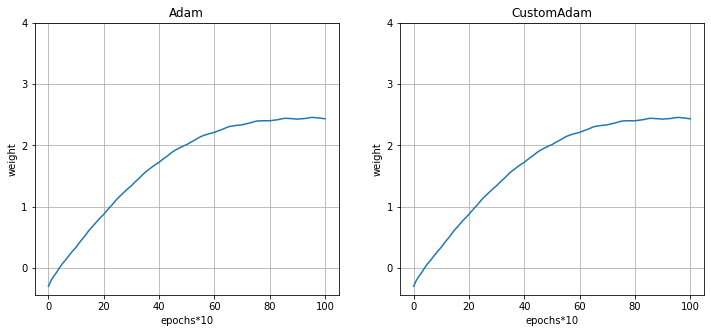

In [7]:
from torch.optim import Adam
w0=optim(model, optim_fn=Adam, lr=0.1,weight_decay=0.5)
w0_custom = optim(model, optim_fn=CustomAdam, lr=0.1,weight_decay=0.5)
plot([w0,w0_custom], titles=['Adam','CustomAdam'])


## 3 SWA

In [8]:
# !pip install torchcontrib
import torchcontrib
model_ = copy.deepcopy(model)
base_opt = SGD(model_.parameters(), 0.01)
opt = torchcontrib.optim.SWA(base_opt)
loss_fn = torch.nn.MSELoss()
for epoch in range(10):
  for i, (input, target) in enumerate(dataloader):
    opt.zero_grad()
    output = model_(input)
    loss = loss_fn(output, target)
    loss.backward()
    opt.step()
    if i > 10 and i % 5 == 0:
      opt.update_swa()
  opt.swap_swa_sgd()

ModuleNotFoundError: ignored